
# Problem 1


## (a)

Set

$$

f(b) = \frac{1}{2n}(y - Xb)^\top(y - Xb)

= \frac{1}{2n}\left(y^\top y - 2b^\top X^\top y + b^\top X^\top X b\right).

$$

Take the gradient and hessian of $f(b)$, we get

$$

\nabla_b f(b) = \frac{1}{n}(X^\top X b - X^\top y).

$$

$$

\nabla^2_b f(b) = \frac{1}{n} X^\top X.

$$

Since $X^\top X$ is positive semidefinite, we have $\nabla^2 f(b) \succeq 0$,

Hence $f(b)$ is convex, $\hat \beta$ is one of the optimal solutions if and only if satisfies $\nabla_b f(\hat \beta) = 0$ .


* $n \geq p$

$X$ has full column rank, then $X^\top X$ is invertible, and the unique solution $\hat \beta$ is

$$

\hat\beta = (X^\top X)^{-1} X^\top y.

$$

*  $n < p$

When $n < p$ and $X$ has full row rank, All solutions of normal equations satisfy 
$$
Xb = \hat y, \quad \text{where } \hat y = P_X y = X (XX^\top)^{-1} X^\top y.
$$
Hence the set of least squares solutions is
$$
\mathcal S = \{\, b \in \mathbb R^p : Xb = \hat y \,\} = \{\, b_0 + v : v \in \ker(X) \,\}, \quad 
b_0 = X^\top (XX^\top)^{-1} y.
$$

Among all solutions in $\mathcal S$, the one with minimal $\ell_2$ norm is the orthogonal projection of $0$ onto this affine space, which is 
$$
\hat\beta = X^\top (XX^\top)^{-1} y.
$$

#### Degrees of freedom
$$
\hat y = X \hat\beta = Hy, \qquad H := 
\begin{cases}
X(X^\top X)^{-1} X^\top , & n \ge p, \\
XX^\top (XX^\top)^{-1} , & n < p.
\end{cases}
$$
By Stein’s lemma, the degrees of freedom is
$$
\text{df} = \mathbb E\!\left[\sum_{i=1}^n \frac{\partial \hat y_i}{\partial y_i}\right]
= \operatorname{tr}(H).
$$

- If $n \ge p$ 
$$
H = X(X^\top X)^{-1} X^\top,
$$
which is the orthogonal projection onto $\operatorname{col}(X)$, and 
$$
\text{df} = \operatorname{tr}(H) = p.
$$

- If $n < p$ (full row rank)
$$
H = X X^\top (XX^\top)^{-1} = I_n,
$$
hence
$$
\text{df} = \operatorname{tr}(I_n) = n.
$$

Therefore, in general
$$
\text{df} = \min(n,p).
$$


## (b)

In the noiseless setting, the original model yields neither bias nor variance. Following Belkin et al. (2019), we therefore introduce an additive noise term into the model in order to capture the bias–variance trade-off and the double descent phenomenon:

$$
y_i = x_i^\top \beta^* + \varepsilon_i, \qquad i=1,\dots,n,
$$

where
$$
x_i \sim \mathcal N(0, I_p), \quad 
\varepsilon_i \sim \mathcal N(0,\sigma^2), \quad 
\varepsilon_i \perp x_i.
$$

We use Monte Carlo simulations to estimate the following quantities:

$$
\text{Bias}(x) = \mathbb{E}_{\text{train}}\!\left[x^\top \hat{\beta}\right] - x^\top \beta^*,
$$

$$
\text{Var}(x) = \mathbb{E}_{\text{train}}\!\Big[\big(x^\top \hat{\beta} - \mathbb{E}_{\text{train}}[x^\top \hat{\beta}]\big)^2\Big].
$$


In [52]:
import numpy as np
import matplotlib.pyplot as plt


def pinv_svd(X, tol=1e-10):
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    s_inv = np.zeros_like(s)
    s_inv[s > tol] = 1.0 / s[s > tol]
    return (Vt.T * s_inv) @ U.T

def mc_bias_var(p=200, gammas=None, M=200, beta_star=None, seed=0, 
                n_test=2000, sigma=0.5):

    rng = np.random.default_rng(seed)
    if gammas is None:
        gammas = np.linspace(0.2, 2.0, 16)
    if beta_star is None:
        v = rng.standard_normal(p)
        beta_star = v / np.linalg.norm(v)

    bias2_list, var_list, excess_risk_list, test_mse_list = [], [], [], []

    for gamma in gammas:
        n = max(1, int(round(gamma * p)))
        betas = []
        test_errors = []
        excess_errors = []

        for _ in range(M):
            # Training set
            X = rng.standard_normal((n, p))
            eps = rng.normal(0.0, sigma, size=n)
            y = X @ beta_star + eps


            if n >= p:
                XtX = X.T @ X
                beta_hat = np.linalg.solve(XtX, X.T @ y)
            else:
                beta_hat = pinv_svd(X) @ y

            betas.append(beta_hat)

            # Test set
            X_test = rng.standard_normal((n_test, p))
            eps_test = rng.normal(0.0, sigma, size=n_test)
            y_test = X_test @ beta_star + eps_test

            y_pred = X_test @ beta_hat
            # MSE on test set
            test_errors.append(np.mean((y_test - y_pred) ** 2))
            # E[(x^T(β̂-β*))^2]
            excess_errors.append(np.mean((X_test @ (beta_hat - beta_star)) ** 2))

        betas = np.stack(betas, axis=0)
        beta_mean = betas.mean(axis=0)

        # Bias², Var（Σ=I）
        bias2 = float(np.sum((beta_mean - beta_star) ** 2))
        var = float(np.mean(np.sum((betas - beta_mean) ** 2, axis=1)))
        excess_risk = float(np.mean(excess_errors))
        test_mse = float(np.mean(test_errors))

        bias2_list.append(bias2)
        var_list.append(var)
        excess_risk_list.append(excess_risk)
        test_mse_list.append(test_mse)

    return (np.array(gammas), np.array(bias2_list), np.array(var_list),
            np.array(excess_risk_list), np.array(test_mse_list))

# ------------ Run & Plot (single figure) ------------
if __name__ == "__main__":
    p = 150

    gammas_left  = np.linspace(0.1, 0.9, 20, endpoint=False)
    gammas_mid   = np.linspace(0.9, 1.1, 20, endpoint=True)  # dense near 1
    gammas_right = np.linspace(1.1, 3.0, 20, endpoint=False)

    gammas = np.unique(np.concatenate([gammas_left, gammas_mid, gammas_right]))
    M = 300


    gammas, bias2, var, excess_risk, test_mse = mc_bias_var(
        p=p, gammas=gammas, M=M, seed=42, sigma=0.5
    )




##### Trade-off between bias and variance

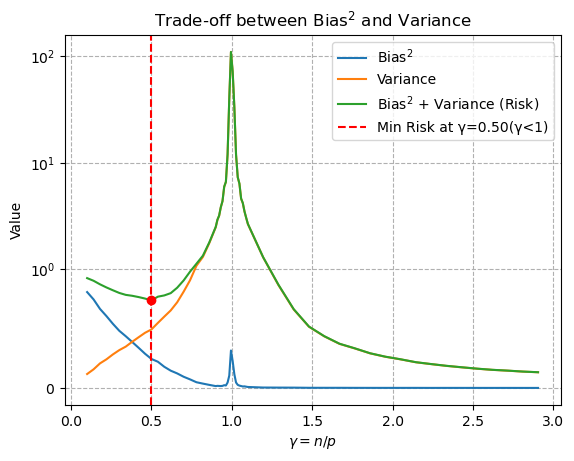

In [53]:
risk = bias2 + var

mask = gammas < 1
risk_under = risk[mask]
gammas_under = gammas[mask]

min_idx = np.argmin(risk_under)
gamma_min = gammas_under[min_idx]
risk_min = risk_under[min_idx]


plt.figure()
plt.plot(gammas, bias2, label='Bias$^2$', color='tab:blue')
plt.plot(gammas, var, label='Variance', color='tab:orange')
plt.plot(gammas, risk, label='Bias$^2$ + Variance (Risk)', color='tab:green')

plt.axvline(x=gamma_min, color='red', linestyle='--', label=f'Min Risk at γ={gamma_min:.2f}(γ<1)')
plt.scatter([gamma_min], [risk_min], color='red', zorder=5)

plt.xlabel(r'$\gamma = n/p$')
plt.ylabel('Value')
plt.title('Trade-off between Bias$^2$ and Variance')
plt.legend()
plt.grid(True, ls="--")
plt.yscale('symlog', linthresh=1)  
plt.show()

In the underparameterized regime ($\gamma < 1$), we observe that the bias decreases while the variance increases, implying a clear trade-off between the two.  
As a result, the overall risk curve attains its minimum at an intermediate point (in this case around $\gamma = 0.5$).  
This occurs because, when the number of parameters is much smaller than the sample size, the model is too simple and cannot fully capture the signal (high bias but low variance).  
As the model capacity increases, the bias is reduced, but the variance grows due to increased sensitivity to the training data.  
The balance between these two effects determines the location of the minimum risk.  


##### Double-descent

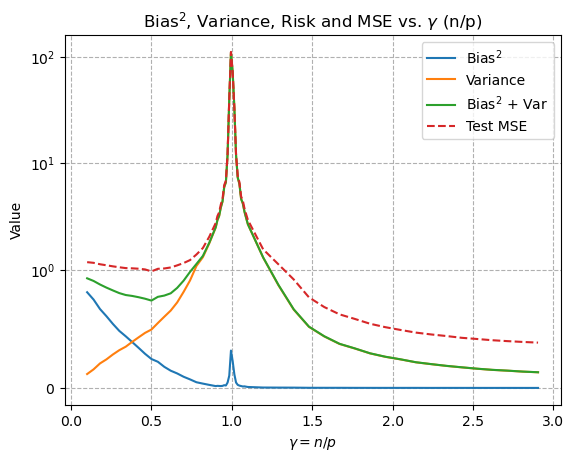

In [54]:
# Visualizatino
c1, c2, c3, c4 = 'tab:blue', 'tab:orange', 'tab:green', 'tab:red'

plt.figure()

plt.plot(gammas, bias2, color=c1, label='Bias$^2$')
plt.plot(gammas, var,   color=c2, label='Variance')
plt.plot(gammas, bias2 + var, color=c3, label='Bias$^2$ + Var')
plt.plot(gammas, test_mse, color=c4, linestyle='--', label='Test MSE')

plt.xlabel(r'$\gamma = n/p$')
plt.ylabel('Value')
plt.title('Bias$^2$, Variance, Risk and MSE vs. $\gamma$ (n/p)')

ax = plt.gca()
ax.set_yscale('symlog', linthresh=1)   
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

In the underparameterized regime ($\gamma < 1$), the risk and test MSE first decrease as the model capacity increases.  
As $\gamma$ approaches 1, the risk and test MSE grow rapidly and exhibit a sharp peak due to the variance explosion at the interpolation threshold.It is generally believed that when the model capacity becomes too large, the model tends to fit the noise and its performance deteriorates, which aligns with the behavior near $\gamma = 1$. However, when $\gamma > 1$, the risk and test MSE decrease again and eventually reach a level even lower than the minimum achieved in the underparameterized regime. 

These results are consistent with the mechanism discussed in Belkin et al. (2019). At the interpolation threshold ($\gamma \approx 1$), the model is forced to exactly fit both the signal and the noise, which leads to a variance explosion and a sharp peak in the risk. In the overparameterized regime ($\gamma > 1$), however, the learning algorithm implicitly selects the minimum-norm interpolating solution, which carries an inductive bias toward smoother and lower-complexity predictor. This bias reduces variance and improves generalization, thereby driving the second descent in the risk curve.  


## （C）

Yes.

$$
\|y - X\beta^{(k+1)}\|_2^2
= \Big\| y - X\Big(\beta^{(k)} + \varepsilon \tfrac{1}{n}X^\top (y - X\beta^{(k)})\Big)\Big\|_2^2
= \Big\|(I - \varepsilon \tfrac{XX^\top}{n})(y - X\beta^{(k)})\Big\|_2^2.
$$

Hence
$$
\|y - X\beta^{(k+1)}\|_2^2
\le \Big\|I - \varepsilon \tfrac{XX^\top}{n}\Big\|_2^2 \cdot \|y - X\beta^{(k)}\|_2^2.
$$



Since $XX^\top/n$ is symmetric positive semidefinite,
$$
\Big\|I - \varepsilon \tfrac{XX^\top}{n}\Big\|_2
= \max_i |1 - \varepsilon \lambda_i(XX^\top/n)|.
$$

Because
$
0 < \varepsilon < \tfrac{1}{\lambda_{\max}(X^\top X/n)},
$

$$
|1 - \varepsilon \lambda_i| < |1-\frac{\lambda_i}{\lambda_{max}}|\le 1.
$$

Thus on $\mathrm{col}(X)$ the residual contracts to $0$, while on $\mathrm{col}(X)^\perp$ it remains fixed, i.e.
$$
r^{(k)} :=y-X\beta^{(k)} \to (I - P_{\mathrm{col}(X)})y,
$$
which implies
$$
\beta^{(k)} \to \beta, \qquad 
\beta \in \arg\min_\beta \tfrac{1}{2n}\|y - X\beta\|_2^2.
$$


Since $\beta^{(0)}=0$ and each update adds a vector in $\mathrm{row}(X^\top)$, all iterates $\beta^{(k)}$ remain in $\mathrm{row}(X^\top)$.  

The set of least–squares solutions is
$$
\{\widehat\beta+v:\ v\in \mathrm{null}(X)\}.
$$
Among them, the unique solution in $\mathrm{row}(X^\top)$ is the minimal–norm solution. Hence the gradient descent limit is the same as in (a)


In [55]:
import numpy as np

def gd_least_squares(X, y, epsilon, max_iter=10000, tol=1e-8):
    n, p = X.shape
    beta = np.zeros((p, 1))   
    for k in range(max_iter):
        grad_step = (X.T @ (y - X @ beta)) / n   
        beta_new = beta + epsilon * grad_step
        if np.linalg.norm(beta_new - beta) < tol:
            break
        beta = beta_new
    return beta

np.random.seed(0)

for (n, p) in [(50, 30), (30, 50)]: 
    print(f"\nCase: n={n}, p={p}")

    X = np.random.randn(n, p)
    beta_star = np.random.randn(p, 1)
    y = X @ beta_star  


    L = np.linalg.eigvalsh((X.T @ X) / n).max()
    epsilon = 1.0 / (2 * L)  

    beta_gd = gd_least_squares(X, y, epsilon)

    if n >= p and np.linalg.matrix_rank(X) == p: 
        beta_opt = np.linalg.inv(X.T @ X) @ (X.T @ y)
    else:  
        beta_opt = X.T @ np.linalg.inv(X @ X.T) @ y

    print("Iteration solution (first 5 entries):", beta_gd[:5].T)
    print("Theoretical solution (first 5 entries):", beta_opt[:5].T)
    print("Difference norm:", np.linalg.norm(beta_gd - beta_opt))



Case: n=50, p=30
Iteration solution (first 5 entries): [[ 0.01323971 -0.12194475  0.33905937 -0.58963196 -0.89581578]]
Theoretical solution (first 5 entries): [[ 0.01323977 -0.12194493  0.33905926 -0.58963204 -0.89581576]]
Difference norm: 6.290798012707873e-07

Case: n=30, p=50
Iteration solution (first 5 entries): [[ 0.22285521  0.27004462 -1.23025339 -0.14050195  0.16496224]]
Theoretical solution (first 5 entries): [[ 0.22285524  0.27004482 -1.23025344 -0.14050202  0.16496237]]
Difference norm: 1.0299158572234506e-06


## （D）


$$
\frac{d\beta(t)}{dt}+\frac{1}{n}X^\top X\,\beta(t)=\frac{1}{n}X^\top y.
$$

Using the variation-of-constants formula with the matrix exponential of $X^\top X$,
$$
\beta(t)=\int_{0}^{t}\exp\!\Big(-\frac{t-s}{n}X^\top X\Big)\,\frac{1}{n}X^\top y\,ds.
$$

u=t-s:
$$
\beta(t)=\int_{0}^{t}\exp\!\Big(-\frac{u}{n}X^\top X\Big)\,\frac{1}{n}X^\top y\,du.
$$

For $n\ge p,\ \mathrm{rank}(X)=p$,
  $$
  \int_0^t \exp\!\Big(-\frac{u}{n}X^\top X\Big)\,du
  = n\,(X^\top X)^{-1}\!\Big(I-\exp\!\big(-\tfrac{t}{n}X^\top X\big)\Big),
  $$
  hence
  $$
\beta(t)=\Big(I-\exp\!\big(-\tfrac{t}{n}X^\top X\big)\Big)\,(X^\top X)^{-1}X^\top y.
  $$

For $p>n$ , replace the inverse by the Moore–Penrose pseudoinverse:
  $$
\beta(t)=\Big(I-\exp\!\big(-\tfrac{t}{n}X^\top X\big)\Big)\,(X^\top X)^{+}X^\top y.
  $$

## (E)


$$
X^\top X = V \Lambda V^\top, \qquad 
\Lambda = \mathrm{diag}(\lambda_1,\dots,\lambda_p).
$$

- **Gradient flow (finite time):**
$$
\hat\beta(t) 
= V \,\mathrm{diag}\!\left(\frac{1-e^{-(t/n)\lambda_j}}{\lambda_j}\right) V^\top X^\top y.
$$

- **Ridge regression:**
$$
\hat\beta(\lambda) 
= (X^\top X + n\lambda I)^{-1} X^\top y
= V \,\mathrm{diag}\!\left(\frac{1}{\lambda_j+n\lambda}\right) V^\top X^\top y.
$$

Both solutions share the same eigenvector directions $V$, hence their directions in coefficient space are aligned. The only difference lies in the shrinkage factors applied along each eigendirection:

- Ridge: $\; 1/(\lambda_j + n\lambda)$  
- Gradient flow: $\; (1-e^{-(t/n)\lambda_j})/\lambda_j$



The following figure depicts the cosine similarity between the two vectors as a function of the parameters. Apart from minor numerical instabilities at the extreme values of the parameters (very large or very small), the cosine similarity remains essentially equal to 1, indicating near-perfect alignment.

/var/folders/s9/dwmbdjrn0rsdf992gy9545_m0000gn/T/ipykernel_24941/3640891642.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((a.T @ b) / (na * nb))


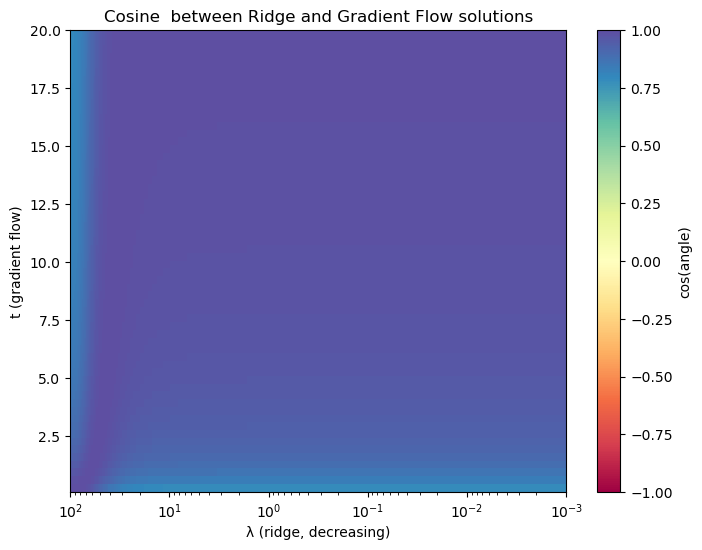

In [56]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)


n, p = 60, 80
X = np.random.randn(n, p)
beta_star = np.random.randn(p, 1)
y = X @ beta_star + 0.1*np.random.randn(n, 1)


lambdas = np.logspace(-3, 2, 60)

ridge_solutions = [np.linalg.inv(X.T @ X + n*l*np.eye(p)) @ (X.T @ y) for l in lambdas]


eigvals, eigvecs = np.linalg.eigh(X.T @ X)
t_vals = np.linspace(0.1, 20, 60)
gf_solutions = []
for t in t_vals:
    shrink_diag = (1 - np.exp(-t*eigvals/n)) / np.where(eigvals > 1e-12, eigvals, 1)
    shrink = np.diag(shrink_diag)
    beta_t = eigvecs @ shrink @ eigvecs.T @ X.T @ y
    gf_solutions.append(beta_t)


def cos_sim(a, b):
    na, nb = np.linalg.norm(a), np.linalg.norm(b)
    if na < 1e-12 or nb < 1e-12:
        return 0.0
    return float((a.T @ b) / (na * nb))

cos_matrix = np.zeros((len(lambdas), len(t_vals)))
for i, b_ridge in enumerate(ridge_solutions):
    for j, b_gf in enumerate(gf_solutions):
        cos_matrix[i, j] = cos_sim(b_ridge, b_gf)


plt.figure(figsize=(8,6))
im = plt.imshow(
    cos_matrix.T,
    extent=[lambdas.min(), lambdas.max(), t_vals.min(), t_vals.max()],
    origin="lower", aspect="auto",
    cmap="Spectral", vmin=-1, vmax=1
)
plt.xscale("log")
plt.gca().invert_xaxis()  
plt.xlabel("λ (ridge, decreasing)")
plt.ylabel("t (gradient flow)")
plt.title("Cosine  between Ridge and Gradient Flow solutions")
plt.colorbar(im, label="cos(angle)")
plt.show()



让我们来观察shrinkfactor和vector norm的变化

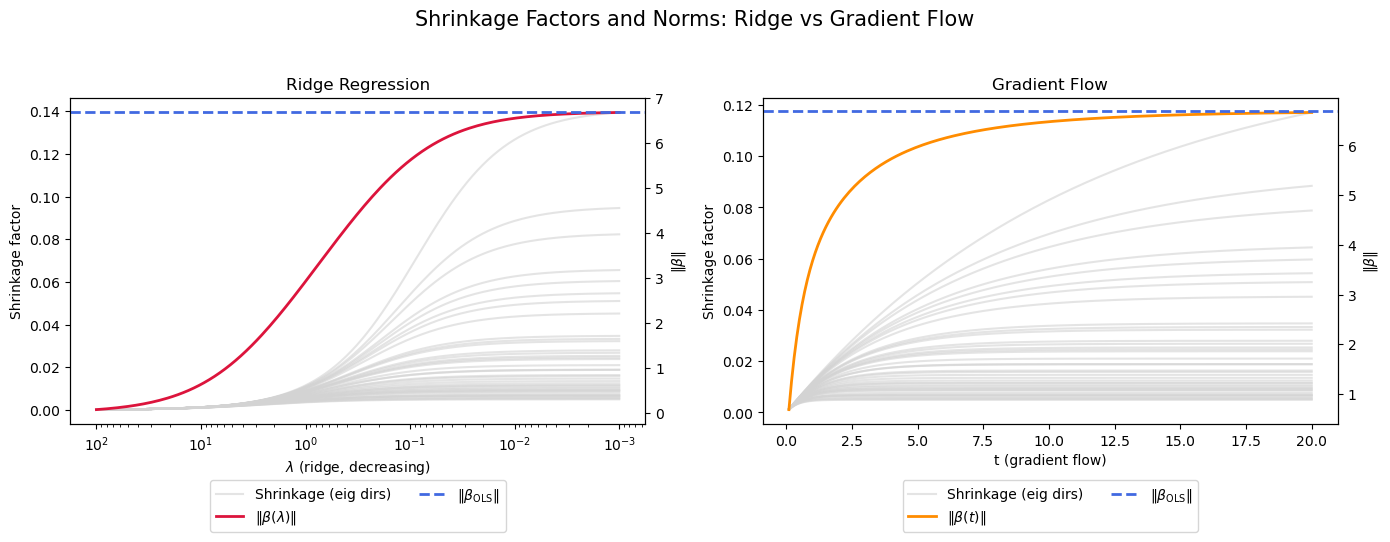

In [57]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# ===== 数据 =====
n, p = 80, 40
X = np.random.randn(n, p)
beta_star = np.random.randn(p, 1)
y = X @ beta_star + 0.1*np.random.randn(n, 1)

# ===== 特征分解 =====
eigvals, eigvecs = np.linalg.eigh(X.T @ X)

# ===== Ridge: λ grid (从大到小) =====
lambdas = np.logspace(2, -3, 200)
shrink_ridge = [1 / (lam_j + n*lambdas) for lam_j in eigvals if lam_j > 1e-12]

beta_ridge = [np.linalg.inv(X.T @ X + n*l*np.eye(p)) @ (X.T @ y) for l in lambdas]
norm_ridge = [np.linalg.norm(b) for b in beta_ridge]

# ===== Gradient Flow: t grid =====
t_vals = np.linspace(0.1, 20, 200)
shrink_gf = [(1 - np.exp(-t_vals*lam_j/n)) / lam_j for lam_j in eigvals if lam_j > 1e-12]

beta_gf = []
for t in t_vals:
    diag = (1 - np.exp(-t*eigvals/n)) / np.where(eigvals > 1e-12, eigvals, 1.0)
    shrink = np.diag(diag)
    beta_t = eigvecs @ shrink @ eigvecs.T @ X.T @ y
    beta_gf.append(beta_t)
norm_gf = [np.linalg.norm(b) for b in beta_gf]

# ===== OLS 范数 =====
beta_ols = np.linalg.pinv(X) @ y
norm_ols = np.linalg.norm(beta_ols)

# ===== 绘图 =====
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# --- (a) Ridge ---
ax1 = axes[0]
for i, shrink in enumerate(shrink_ridge):
    ax1.plot(lambdas, shrink, color="lightgray", alpha=0.6,
             label="Shrinkage (eig dirs)" if i==0 else None)
ax1.set_xscale("log")
ax1.invert_xaxis()
ax1.set_xlabel(r"$\lambda$ (ridge, decreasing)")
ax1.set_ylabel("Shrinkage factor")
ax1.set_title("Ridge Regression")

ax2 = ax1.twinx()
ax2.plot(lambdas, norm_ridge, color="crimson", lw=2, label=r"$\|\beta(\lambda)\|$")
ax2.axhline(norm_ols, color="royalblue", ls="--", lw=2, label=r"$\|\beta_{\rm OLS}\|$")
ax2.set_ylabel(r"$\|\beta\|$")

# legend outside
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2, loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)

# --- (b) Gradient Flow ---
ax3 = axes[1]
for i, shrink in enumerate(shrink_gf):
    ax3.plot(t_vals, shrink, color="lightgray", alpha=0.6,
             label="Shrinkage (eig dirs)" if i==0 else None)
ax3.set_xlabel("t (gradient flow)")
ax3.set_ylabel("Shrinkage factor")
ax3.set_title("Gradient Flow")

ax4 = ax3.twinx()
ax4.plot(t_vals, norm_gf, color="darkorange", lw=2, label=r"$\|\beta(t)\|$")
ax4.axhline(norm_ols, color="royalblue", ls="--", lw=2, label=r"$\|\beta_{\rm OLS}\|$")
ax4.set_ylabel(r"$\|\beta\|$")

# legend outside
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
ax3.legend(lines3+lines4, labels3+labels4, loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.suptitle("Shrinkage Factors and Norms: Ridge vs Gradient Flow", fontsize=15)
plt.tight_layout(rect=[0,0.05,1,0.95])
plt.show()


We can observe how the parameters $\lambda$ (in ridge regression) and $t$ (in gradient flow)  
control the shrinkage along different eigendirections and consequently affect the overall norm of $\beta$.

- In **ridge regression**, increasing $\lambda$ shrinks the coefficients more strongly,  
  since the shrinkage factor $\frac{1}{\lambda_j + n\lambda}$ decreases with $\lambda$.  
  Thus, the overall norm $\|\beta(\lambda)\|$ increases as $\lambda$ decrease and converges to $\|\beta_{\text{OLS}}\|$ 
  as $\lambda$ converge to 0.

- In **gradient flow**, increasing $t$ enlarges the coefficients toward the OLS solution,  
  since the shrinkage factor $\frac{1 - e^{-(t/n)\lambda_j}}{\lambda_j}$ increases monotonically with $t$.  
  Hence, the overall norm $\|\beta(t)\|$ increases with $t$ and converges to $\|\beta_{\text{OLS}}\|$.


# Problem 2

## (a)

$$z_i=\mu_i+\varepsilon_i,\quad\mu_i\sim\mathcal{N}(0,\Sigma),
\begin{array}
{c}\varepsilon_i\sim\mathcal{N}(0,I_2),
\end{array}\mu_i\perp\perp\varepsilon_i.$$

The sum of independent Gaussian random variables is still Gaussian, with means added and covariances added. Hence
$$z_i\sim\mathcal{N}\left(0,\mathrm{~}\Sigma+I_2\right)$$

By maximum likelihood, the covariance matrix $\Sigma$ is estimated as  

$$
\widehat{\Sigma} \;=\; S_z - I_2, 
\qquad 
S_z \;=\; \frac{1}{N}\sum_{i=1}^N z_i z_i^\top,
$$

where $S_z$ denotes the sample covariance.And $\hat \Sigma$ is an unbiased estimator.




$$p(\mu|z)\propto\left.p(z|\mu)\right.p(\mu)=\mathcal{N}(z;\mu,I)\mathcal{N}(\mu;0,\Sigma).$$


$$\mu|z\sim\mathcal{N}\left(\Sigma(\Sigma+I)^{-1}z,\:\Sigma-\Sigma(\Sigma+I)^{-1}\Sigma\right).$$

Hence we can deduce
$$\hat{\mu}=\hat \Sigma(\hat \Sigma+I)^{-1}z$$

## (b)（C）
因为在（b）中会在多种情况下进行simulation试验，因此这里将同时进行理关于理论的discussion，使得整个讨论的结构更加清晰

First the code generate the data with the form in problem

首先给出在simulation中使用的james-stein extimator and （a）中提出的estimator的代码实现

Standard JSE work with
$$
\begin{aligned}
\hat{\mu}_{A}^{JS} & =\left(1-\frac{N-2}{\|z_{A}\|^{2}}\right)z_{A}, \\
 \\
\hat{\mu}_{B}^{JS} & =\left(1-\frac{N-2}{\|z_{B}\|^{2}}\right)z_{B},
\end{aligned}
$$


the estimator prompted in （a） work with
$$\hat{\mu}=\hat \Sigma(\hat \Sigma+I)^{-1}z$$

In [58]:
from typing import Tuple, Dict

# ---------- 1) 标准 JSE：对每个 task 独立 ----------
def james_stein_1task(z: np.ndarray, noise_var: float = 1.0, clip_nonneg: bool = True):
    """
    Standard JS estimator for a single task:
        z ~ N(mu, noise_var * I_N),  JS: (1 - (N-2) * noise_var / ||z||^2) * z
    """
    z = np.asarray(z).ravel()
    N = z.size
    denom = np.dot(z, z)
    if denom <= 0:
        return np.zeros_like(z)
    shrink = 1.0 - (N - 2) * noise_var / denom
    if clip_nonneg:
        shrink = max(0.0, shrink)
    return shrink * z, shrink

def james_stein_two_tasks(zA: np.ndarray, zB: np.ndarray, noise_var: float = 1.0, clip_nonneg: bool = True):
    muA_hat, sA = james_stein_1task(zA, noise_var, clip_nonneg)
    muB_hat, sB = james_stein_1task(zB, noise_var, clip_nonneg)
    return {"muA_hat_JS": muA_hat, "muB_hat_JS": muB_hat, "shrink_A": sA, "shrink_B": sB}

# ---------- 2) 线性收缩（估 Sigma → 后验均值） ----------
def estimate_Sigma_from_Z(Z: np.ndarray, noise_var: float = 1.0, ridge: float = 0.0):
    """
    Z: shape (2, N), columns are z_i = [z_Ai, z_Bi].
    Returns a PSD estimate of Sigma via S_z - noise_var*I, optionally with ridge.
    """
    Z = np.asarray(Z)
    assert Z.shape[0] == 2, "Z must be 2×N"
    # 样本协方差（无偏/有偏差别不大，这里用 1/N）
    Sz = (Z @ Z.T) / Z.shape[1]
    Sigma_hat = Sz - noise_var * np.eye(2)
    # 数值安全：投影到 PSD，并可加 ridge
    evals, evecs = np.linalg.eigh(Sigma_hat)
    evals = np.clip(evals, 0.0, None)
    Sigma_hat_psd = (evecs * (evals + ridge)) @ evecs.T
    return Sigma_hat_psd

def linear_shrinkage_mu(Z: np.ndarray, noise_var: float = 1.0, ridge: float = 0.0):
    """
    Posterior-mean style linear shrinkage:
        mu_hat_i = W z_i,  with  W = Sigma_hat (Sigma_hat + noise_var I)^(-1)
    """
    Sigma_hat = estimate_Sigma_from_Z(Z, noise_var=noise_var, ridge=ridge)
    W = Sigma_hat @ np.linalg.inv(Sigma_hat + noise_var * np.eye(2))
    MU_hat = W @ Z   # shape (2, N)
    return MU_hat, W, Sigma_hat




### 相关系数的影响


在这个部分中我们考虑xxx
数据生成函数

In [59]:

def sample_two_task_data(
    N: int,
    sigma_A: float = 1.0,
    sigma_B: float = 1.0,
    rho: float = 0.0,
    noise_std: float = 1.0,
    seed: int = None
) -> Dict[str, np.ndarray]:
    """
    Generate data for the two-task James–Stein extension.

    Model:
        [mu_A, mu_B]^T ~ N(0, Sigma),
        z_A | mu_A ~ N(mu_A, noise_std^2),
        z_B | mu_B ~ N(mu_B, noise_std^2),
        for i = 1..N (i.i.d. across i).

    Args
    ----
    N : number of coordinates/items per task.
    sigma_A, sigma_B : prior std of mu_A, mu_B (marginals).
    rho : correlation between mu_A and mu_B (must be in [-1, 1]).
    noise_std : observation noise std (default 1.0).
    seed : optional rng seed.

    Returns
    -------
    dict with keys:
        'mu_A', 'mu_B', 'Z_A', 'Z_B', 'Sigma'
    each of shape (N,), except 'Sigma' is (2,2).
    """
    if not -1.0 <= rho <= 1.0:
        raise ValueError("rho must be in [-1, 1].")

    rng = np.random.default_rng(seed)

    # Prior covariance Sigma
    Sigma = np.array([
        [sigma_A**2, rho * sigma_A * sigma_B],
        [rho * sigma_A * sigma_B, sigma_B**2]
    ], dtype=float)

    # Numerical safety: project tiny negative eigenvalues to 0
    evals, evecs = np.linalg.eigh(Sigma)
    if np.any(evals < -1e-12):
        raise ValueError("Sigma is not PSD; check (sigma_A, sigma_B, rho).")
    evals = np.clip(evals, 0.0, None)
    Sigma = (evecs * evals) @ evecs.T  # reconstructed PSD Sigma

    # Cholesky (use eigh→chol fallback for semi-definite)
    # Add tiny jitter if needed for numerical stability
    jitter = 0.0
    try:
        L = np.linalg.cholesky(Sigma)
    except np.linalg.LinAlgError:
        jitter = 1e-12
        L = np.linalg.cholesky(Sigma + jitter * np.eye(2))

    # Sample mus: shape (2, N)
    standard = rng.standard_normal(size=(2, N))
    MU = L @ standard  # columns are [mu_A_i; mu_B_i]

    mu_A, mu_B = MU[0], MU[1]

    # Observation noise
    eps_A = rng.normal(loc=0.0, scale=noise_std, size=N)
    eps_B = rng.normal(loc=0.0, scale=noise_std, size=N)

    # Observations
    Z_A = mu_A + eps_A
    Z_B = mu_B + eps_B

    return {
        "mu_A": mu_A,
        "mu_B": mu_B,
        "Z_A": Z_A,
        "Z_B": Z_B,
        "Sigma": Sigma
    }


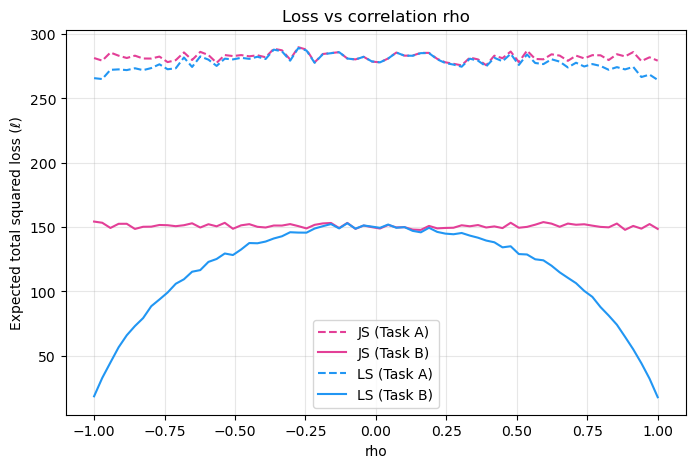

In [60]:

import matplotlib.pyplot as plt

rhos = np.linspace(-1, 1, 70)   
reps = 50                       # 每个 rho 重复次数

loss_JS_A, loss_JS_B = [], []
loss_LS_A, loss_LS_B = [], []

for rho in rhos:
    acc_JS_A = acc_JS_B = 0.0
    acc_LS_A = acc_LS_B = 0.0
    
    for r in range(reps):
        data = sample_two_task_data(
            N=300, sigma_A=4.0, sigma_B=1.0, rho=rho, noise_std=1.0, seed=None
        )
        zA, zB = data["Z_A"], data["Z_B"]
        Z = np.vstack([zA, zB])
        muA_true, muB_true = data["mu_A"], data["mu_B"]

        # --- JSE ---
        js_res = james_stein_two_tasks(zA, zB, noise_var=1.0, clip_nonneg=True)
        muA_hat_JS, muB_hat_JS = js_res["muA_hat_JS"], js_res["muB_hat_JS"]

        acc_JS_A += np.sum((muA_hat_JS - muA_true)**2)
        acc_JS_B += np.sum((muB_hat_JS - muB_true)**2)

        # --- Linear Shrinkage ---
        MU_hat_LS, W, Sigma_hat = linear_shrinkage_mu(Z, noise_var=1.0, ridge=1e-8)
        muA_hat_LS, muB_hat_LS = MU_hat_LS[0], MU_hat_LS[1]

        acc_LS_A += np.sum((muA_hat_LS - muA_true)**2)
        acc_LS_B += np.sum((muB_hat_LS - muB_true)**2)

    # 平均
    loss_JS_A.append(acc_JS_A / reps)
    loss_JS_B.append(acc_JS_B / reps)
    loss_LS_A.append(acc_LS_A / reps)
    loss_LS_B.append(acc_LS_B / reps)

# ----- 作图 -----

plt.figure(figsize=(8,5))

# JSE: 粉色
plt.plot(rhos, loss_JS_A, color="#e33f97", linestyle="--", label="JS (Task A)")
plt.plot(rhos, loss_JS_B, color="#e33f97", linestyle="-",  label="JS (Task B)")

# LS: 蓝色
plt.plot(rhos, loss_LS_A, color="#2196f3", linestyle="--", label="LS (Task A)")
plt.plot(rhos, loss_LS_B, color="#2196f3", linestyle="-",  label="LS (Task B)")

plt.xlabel("rho")
plt.ylabel("Expected total squared loss (ℓ)")
plt.title("Loss vs correlation rho")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


用用切比雪夫进行最小二乘拟合：

[Task A] Cheb deg=8, R²=0.6957, RMSE=3.0480
[Task B] Cheb deg=8, R²=0.9988, RMSE=1.2699


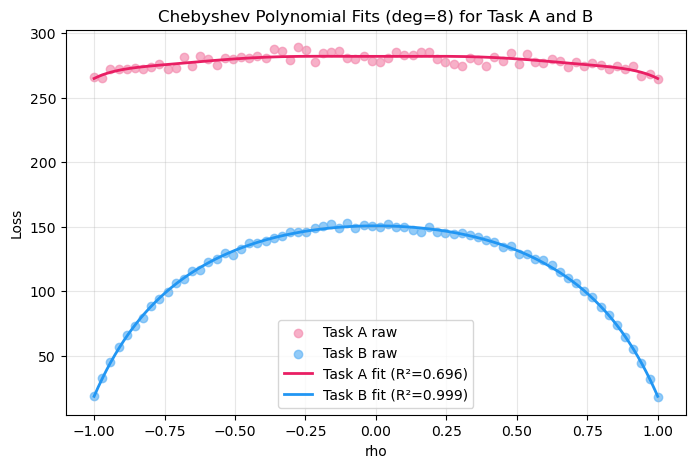

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.chebyshev import chebfit, chebval

# ===== 数据 =====
x = np.asarray(rhos)
yA = np.asarray(loss_LS_A)
yB = np.asarray(loss_LS_B)
deg = 8
enforce_even = True

# ===== Task A 拟合 =====
chebA = chebfit(x, yA, deg)
if enforce_even:
    chebA[1::2] = 0.0
x_fine = np.linspace(-1, 1, 400)
yA_fit = chebval(x_fine, chebA)
yA_pred = chebval(x, chebA)
r2A = 1 - np.sum((yA - yA_pred)**2) / np.sum((yA - yA.mean())**2)
rmseA = np.sqrt(np.mean((yA - yA_pred)**2))
print(f"[Task A] Cheb deg={deg}, R²={r2A:.4f}, RMSE={rmseA:.4f}")

# ===== Task B 拟合 =====
chebB = chebfit(x, yB, deg)
if enforce_even:
    chebB[1::2] = 0.0
yB_fit = chebval(x_fine, chebB)
yB_pred = chebval(x, chebB)
r2B = 1 - np.sum((yB - yB_pred)**2) / np.sum((yB - yB.mean())**2)
rmseB = np.sqrt(np.mean((yB - yB_pred)**2))
print(f"[Task B] Cheb deg={deg}, R²={r2B:.4f}, RMSE={rmseB:.4f}")

# ===== 画在同一张图上 =====
plt.figure(figsize=(8,5))
plt.scatter(x, yA, color="#f48fb1", alpha=0.7, label="Task A raw")
plt.scatter(x, yB, color="#64b5f6", alpha=0.7, label="Task B raw")

plt.plot(x_fine, yA_fit, color="#e91e63", linewidth=2, label=f"Task A fit (R²={r2A:.3f})")
plt.plot(x_fine, yB_fit, color="#2196f3", linewidth=2, label=f"Task B fit (R²={r2B:.3f})")

plt.xlabel("rho")
plt.ylabel("Loss")
plt.title(f"Chebyshev Polynomial Fits (deg={deg}) for Task A and B")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


这里应该有一些discussion：
why cheb = 8能够达到这么好的效果？
推导、、、展开、、、、

### 模型错配测试
（感觉可以放一下、如果时间不够的话）
修改成正态分布，但是有相关性质

In [62]:
import numpy as np
import scipy.stats as st

def sample_two_task_data_uniform(
    N: int,
    low: float = -1.0,
    high: float = 1.0,
    noise_std: float = 1.0,
    rho: float = 0.8,   # <--- 新增：相关系数
    seed: int = None,
):
    rng = np.random.default_rng(seed)
    lowb = low * 2
    highb = high * 2

    # 1. 生成相关高斯
    cov = [[1.0, rho], [rho, 1.0]]
    mvn = rng.multivariate_normal([0, 0], cov, size=N)

    # 2. 用正态分布CDF映射到(0,1)
    U = st.norm.cdf(mvn)

    # 3. 映射到不同均匀区间
    mu_A = low + (high - low) * U[:, 0]
    mu_B = lowb + (highb - lowb) * U[:, 1]

    # 4. 加噪声
    eps_A = rng.normal(0.0, noise_std, size=N)
    eps_B = rng.normal(0.0, noise_std, size=N)

    Z_A = mu_A + eps_A
    Z_B = mu_B + eps_B

    return {"mu_A": mu_A, "mu_B": mu_B, "Z_A": Z_A, "Z_B": Z_B}


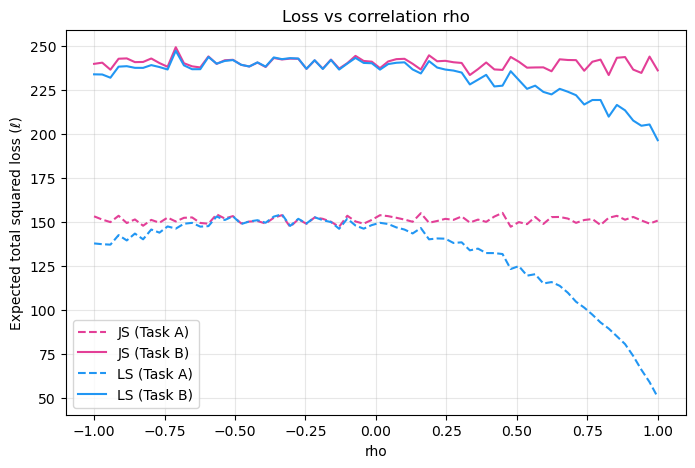

In [63]:

import matplotlib.pyplot as plt

rhos = np.linspace(-1, 1, 70)   
reps = 50                       # 每个 rho 重复次数

loss_JS_A, loss_JS_B = [], []
loss_LS_A, loss_LS_B = [], []

for rho in rhos:
    acc_JS_A = acc_JS_B = 0.0
    acc_LS_A = acc_LS_B = 0.0
    
    for r in range(reps):
        data = sample_two_task_data_uniform(
            N=300, low=-2, high=1, noise_std=1.0, seed=None, rho=rho
        )
        zA, zB = data["Z_A"], data["Z_B"]
        Z = np.vstack([zA, zB])
        muA_true, muB_true = data["mu_A"], data["mu_B"]

        # --- JSE ---
        js_res = james_stein_two_tasks(zA, zB, noise_var=1.0, clip_nonneg=True)
        muA_hat_JS, muB_hat_JS = js_res["muA_hat_JS"], js_res["muB_hat_JS"]

        acc_JS_A += np.sum((muA_hat_JS - muA_true)**2)
        acc_JS_B += np.sum((muB_hat_JS - muB_true)**2)

        # --- Linear Shrinkage ---
        MU_hat_LS, W, Sigma_hat = linear_shrinkage_mu(Z, noise_var=1.0, ridge=1e-8)
        muA_hat_LS, muB_hat_LS = MU_hat_LS[0], MU_hat_LS[1]

        acc_LS_A += np.sum((muA_hat_LS - muA_true)**2)
        acc_LS_B += np.sum((muB_hat_LS - muB_true)**2)

    # 平均
    loss_JS_A.append(acc_JS_A / reps)
    loss_JS_B.append(acc_JS_B / reps)
    loss_LS_A.append(acc_LS_A / reps)
    loss_LS_B.append(acc_LS_B / reps)

# ----- 作图 -----

plt.figure(figsize=(8,5))

# JSE: 粉色
plt.plot(rhos, loss_JS_A, color="#e33f97", linestyle="--", label="JS (Task A)")
plt.plot(rhos, loss_JS_B, color="#e33f97", linestyle="-",  label="JS (Task B)")

# LS: 蓝色
plt.plot(rhos, loss_LS_A, color="#2196f3", linestyle="--", label="LS (Task A)")
plt.plot(rhos, loss_LS_B, color="#2196f3", linestyle="-",  label="LS (Task B)")

plt.xlabel("rho")
plt.ylabel("Expected total squared loss (ℓ)")
plt.title("Loss vs correlation rho")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Problem3
## （a）

The degrees of freedom can be estimated via Monte Carlo using the following formula:

$$
\mathrm{df} = \frac{1}{\sigma^2} \sum_{i=1}^n \operatorname{Cov}(y_i, \hat{y}_i),
$$

where $\hat{y}_i$ denotes the predicted value for the $i$-th observation and $\sigma^2$ is the noise variance. This covariance-based formula provides a general approach for estimating degrees of freedom under broad model and data assumptions.

在下面的代码中，固定蒙特卡洛随机次数为3000次，选取不同的参数。

In [ ]:
import numpy as np
import pandas as pd

def simulate_df(n, p, sigma=1.0, R=5000, seed=0):
    rng = np.random.default_rng(seed)
    X = rng.normal(size=(n, p))
    beta = rng.normal(size=p)

    # Hat matrix，用伪逆保证数值稳定
    S = X @ np.linalg.pinv(X)  
    df_theory = np.trace(S)

    Ys, Yhats = [], []
    for _ in range(R):
        eps = rng.normal(0, sigma, n)
        y = X @ beta + eps
        yhat = S @ y
        Ys.append(y)
        Yhats.append(yhat)

    Ys = np.array(Ys).T
    Yhats = np.array(Yhats).T

    # 根据协方差定义计算经验自由度
    df_empirical = np.sum([
        np.cov(Ys[i], Yhats[i], ddof=0)[0,1] / sigma**2 for i in range(n)
    ])

    return {"n": n, "p": p, "sigma": sigma, "df": df_empirical}

# 多组参数

results = []
settings = [
    (70, 11, 5.0),
    (80, 20, 2.0),
    (100, 30, 1.0),
    (120, 10, 10.0),
    (100, 99, 10.0),
    (1000, 999, 1.0),
]

for n, p, sigma in settings:
    res = simulate_df(n, p, sigma, R=8000, seed=42)
    results.append(res)

df = pd.DataFrame(results)
df["df"] = df["df"].round(1)   # 只保留一位小数
print(df.to_string(index=False))



   n   p  sigma    df
  70  11    5.0  11.0
  80  20    2.0  20.0
 100  30    1.0  30.0
 120  10   10.0  10.1
 100  99   10.0  99.1
1000 999    1.0 998.2


可以看到即使是在n非常接近p的情况下数值依然相对稳定

我在此之外还进行了一些常见的会让OLS表现糟糕的数值病态情况下的df计算，不过得到的结果并没有显著地变糟糕。所以分析了一下df 的计算过程

when n>p and X is full rank
$$
\hat{y} = S y, \quad S = X(X^\top X)^{-1}X^\top
$$


Since $y = X\beta + \varepsilon$, then
  $$
  \hat{y} = S(X\beta + \varepsilon) = SX\beta + S\varepsilon.
  $$

  $$
  \operatorname{Cov}(y, \hat{y}) = \operatorname{Cov}(X\beta + \varepsilon, SX\beta + S\varepsilon).
  $$
  Since $X\beta$ is fixed, only the noise part remains:
  $$
  \operatorname{Cov}(y, \hat{y}) = \operatorname{Cov}(\varepsilon, S\varepsilon).
  $$

  $$
  \operatorname{Cov}(\varepsilon, S\varepsilon) = \sigma^2 S.
  $$

Therefore,
$$
\frac{1}{\sigma^2}\sum_{i=1}^n \operatorname{Cov}(y_i, \hat{y}_i) = \frac{1}{\sigma^2}\operatorname{tr}(\sigma^2 S) = \operatorname{tr}(S).
$$

$$
\operatorname{tr}(S) = \operatorname{tr}(X(X^TX)^{-1}X^T) = \operatorname{tr}(X^TX(X^TX)^{-1}) = \operatorname{tr}(I_{p\times p}) = p

因此这个df的算法看起来非常的稳健，不太会在极端数据下表现得糟糕。除非X矩阵非常病态X^TX几乎降秩，因此尝试构建极端的数据来验证猜想：

In [66]:
def make_ill_conditioned_X(n, p, cond_target=1e12, seed=0):
    rng = np.random.default_rng(seed)
    # Random orthonormal bases U (n x p) and V (p x p)
    U, _ = np.linalg.qr(rng.normal(size=(n, p)))
    V, _ = np.linalg.qr(rng.normal(size=(p, p)))
    # Singular values decay geometrically from 1 to 1/cond_target
    s_min = 1.0/cond_target
    s = np.geomspace(1.0, s_min, p)
    X = U @ np.diag(s) @ V.T
    return X

def make_near_rank_deficient_X(n, p, k=None, eps=1e-1, seed=0):
    """
    Build X where p-k columns are nearly linear combos of the first k,
    with tiny noise eps. Default k=p-1 to make it 'almost' rank-deficient.
    """
    rng = np.random.default_rng(seed)
    if k is None:
        k = max(1, p-1)
    X_base = rng.normal(size=(n, k))
    # Random mixing to create the remaining columns from X_base
    W = rng.normal(size=(k, p-k))
    X_dep = X_base @ W + eps * rng.normal(size=(n, p-k))
    X = np.concatenate([X_base, X_dep], axis=1)
    return X

def xtx_diagnostics(X):
    XtX = X.T @ X
    # Use SVD-based condition numbers for numerical stability
    svals = np.linalg.svd(X, compute_uv=False)
    cond_X = svals[0]/svals[-1]
    eigvals = np.linalg.eigvalsh(XtX)
    rank = np.linalg.matrix_rank(XtX)
    return {
        "shape": X.shape,
        "cond(X)": float(cond_X),
        "cond(X^T X)": float((cond_X**2)),
        "min_eig(X^T X)": float(eigvals[0]),
        "max_eig(X^T X)": float(eigvals[-1]),
        "rank(X^T X)": int(rank)
    }

import numpy as np

n, p = 120, 30
X1 = make_ill_conditioned_X(n, p, cond_target=1e16, seed=42)     # SVD-based
X2 = make_near_rank_deficient_X(n, p, k=p-5, eps=1e-14, seed=7)  # Almost dependent

diag1 = xtx_diagnostics(X1)
diag2 = xtx_diagnostics(X2)

df_demo_1 = simulate_df(n, p, sigma=1.0, R=5000, seed=123, X=X1)
df_demo_2 = simulate_df(n, p, sigma=1.0, R=5000, seed=123, X=X2)


# -------- 表格式美化输出 --------
print(f"{'Matrix Type':<28} {'(n,p)':>10} {'cond(X)':>15} {'cond(X^T X)':>20} {'df':>10} {'trace(S)':>12}")
print("-"*100)
print(f"{'SVD-based ill-conditioned':<28} {(n,p)!s:>10} {diag1['cond(X)']:>15.2e} {diag1['cond(X^T X)']:>20.2e} {df_demo_1['df']:>10.2f} {df_demo_1['df_hat_traceS']:>12.2f}")
print(f"{'Near rank-deficient':<28} {(n,p)!s:>10} {diag2['cond(X)']:>15.2e} {diag2['cond(X^T X)']:>20.2e} {df_demo_2['df']:>10.2f} {df_demo_2['df_hat_traceS']:>12.2f}")


TypeError: simulate_df() got an unexpected keyword argument 'X'

可以看到，当故意构建一些病态的矩阵，就可以使得$X^TX$中绝对值最小的几个特征值小于机器精度。此时虽然数学意义和推导上依然满足题目的要求，但是simulation得到的结果已经不正确了。

## （b）

求解线性约束的最小二乘

由kkt条件得到
